TODO:
- normalize

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from timeit import default_timer as timer
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from keras.utils import Sequence
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [3]:
def read_class():
    CLASS_NAME = []
    with open('./classes.txt', 'r') as class_file:
        for i, line in enumerate(class_file):
            line = line.rstrip('\n')
            CLASS_NAME.append(line)
    return CLASS_NAME

In [4]:
""" Hyperparameters defined here """
CLASS_NAME = read_class()
NUM_CLASS = len(CLASS_NAME)
TRAIN_DF  = []
TEST_DF   = []
DATA_PATH = '/Volumes/JS/QuickDraw/'
NUM_VALID = 80

In [6]:
def split_dataset():
    all_npy_path = DATA_PATH + 'data_split/train_simplified'
    train_npy_path = DATA_PATH + 'data_split/train_set'
    valid_npy_path = DATA_PATH + 'data_split/valid_set'

    for name in CLASS_NAME:
        name = name.replace('_', ' ')
        df = pd.read_csv(DATA_PATH + 'train_simplified/%s.csv' % name)
        key_id = df['key_id'].values.astype(np.int64)
        np.random.shuffle(key_id)

        n = len(key_id)
        n_valid = NUM_VALID
        n_train = n - n_valid

        np.save(all_npy_path + '/%s.npy' % name, key_id)
        np.save(train_npy_path + '/%s.npy' % name, key_id[:n_train])
        np.save(valid_npy_path + '/%s.npy' % name, key_id[n_train:])
    print('Finish dataset split.')

In [3]:
class Struct(object):
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
        
def drawing_to_image(drawing, H, W):

    point=[]
    time =[]
    
#     coordinates = []
    
    for t,(x,y) in enumerate(drawing):
        point.append(np.array((x,y),np.float32).T)
        time.append(np.full(len(x),t))

    point = np.concatenate(point).astype(np.float32)
    time  = np.concatenate(time).astype(np.int32)

    image  = np.full((H,W,3),0,np.uint8)
    x_max = point[:,0].max()
    x_min = point[:,0].min()
    y_max = point[:,1].max()
    y_min = point[:,1].min()
    w = x_max-x_min
    h = y_max-y_min
    #print(w,h)

    s = max(w,h)
    norm_point = (point-[x_min,y_min])/s
    norm_point = (norm_point-[w/s*0.5,h/s*0.5])*max(W,H)*0.85
    norm_point = np.floor(norm_point + [W/2,H/2]).astype(np.int32)

    T = time.max()+1
    for t in range(T):
        p = norm_point[time==t]
        x,y = p.T
        image[y,x]=255
        N = len(p)
        for i in range(N-1):
            x0,y0 = p[i]
            x1,y1 = p[i+1]
            cv2.line(image,(x0,y0),(x1,y1),(255,255,255),1,cv2.LINE_AA)

    return image


def null_augment(drawing, label, index):
#     cache = Struct(drawing = drawing.copy(), label = label, index=index)
    image = drawing_to_image(drawing, 64, 64)
    return image, label

def time_to_str(t, mode='min'):
    if mode=='min':
        t  = int(t)/60
        hr = t//60
        min = t%60
        return '%2d hr %02d min'%(hr,min)

    elif mode=='sec':
        t   = int(t)
        min = t//60
        sec = t%60
        return '%2d min %02d sec'%(min,sec)

In [5]:
def read_full_df(base_path, class_array, train_split_folder='train_set', valid_split_folder='valid_set'):
    full_df = []
    train_id, valid_id = [], []
    num_class = len(class_array)
    start = timer()
    
    # read full df .csv files
    for i, name in enumerate(class_array):
        print('\r\t load df   :  %3d/%3d %24s  %s'%(i, num_class, name,time_to_str((timer() - start), 'sec')),
              end='',flush=True)
        name = name.replace('_', ' ')

        df = pd.read_csv(base_path + 'train_%s/%s.csv'%('simplified', name))
        full_df.append(df)
    print('\n')
    
    # acquire train split set's id
    for i, name in enumerate(class_array):
        print('\r\t load train_set split:  %3d/%3d %24s  %s'%(i, num_class, name, time_to_str((timer() - start),'sec')), 
              end='', flush=True)
        name = name.replace('_', ' ')
        df = full_df[i]
        key_id = np.load(base_path + 'data_split/%s/%s.npy'%(train_split_folder, name))
        label = np.full(len(key_id), i, dtype=np.int64)
        drawing_id = df.loc[df['key_id'].isin(key_id)].index.values
        train_id.append(np.vstack([label, drawing_id, key_id]).T)
    train_id = np.concatenate(train_id)
    
    # acquire valid split set's id
    for i, name in enumerate(class_array):
        print('\r\t load valid_set split:  %3d/%3d %24s  %s'%(i, num_class, name, time_to_str((timer() - start),'sec')), 
              end='', flush=True)
        name = name.replace('_', ' ')
        df = full_df[i]
        key_id = np.load(base_path + 'data_split/%s/%s.npy'%(valid_split_folder, name))
        label = np.full(len(key_id), i, dtype=np.int64)
        drawing_id = df.loc[df['key_id'].isin(key_id)].index.values
        valid_id.append(np.vstack([label, drawing_id, key_id]).T)
    valid_id = np.concatenate(valid_id)
    
    return full_df, train_id, valid_id

In [6]:
def read_example_df(base_path, class_array, train_split_folder='train_set', valid_split_folder='valid_set'):
    ex_df = []
    angle_id = []
    num_class = len(class_array)
    start = timer()
    
    # read an example category 'angle.csv'
    name = 'angel'
    print('\r\t load df   :  %3d/%3d %24s  %s'%(6, num_class, name,time_to_str((timer() - start), 'sec')),
          end='',flush=True)

    df = pd.read_csv(base_path + 'train_%s/%s.csv'%('simplified', name))
    ex_df.append(df)
    print('\n')
    
    # acquire angle split set's id
    print('\r\t load train_set split:  %3d/%3d %24s  %s'%(0, num_class, name, time_to_str((timer() - start),'sec')), 
          end='', flush=True)
    df = ex_df[0]
    key_id = np.load(base_path + 'data_split/%s/%s.npy'%(train_split_folder, name))
    label = np.full(len(key_id), 0, dtype=np.int64)
    drawing_id = df.loc[df['key_id'].isin(key_id)].index.values
    angle_id.append(np.vstack([label, drawing_id, key_id]).T)

    angle_id = np.concatenate(angle_id)
    
    return ex_df, angle_id

In [8]:
class ImageBatchGenerator(Sequence):
    def __init__(self, 
                 class_array,
                 full_df,
                 datasplit_id,
                 split='train_set',
                 batch_size=128, 
                 augment=null_augment, 
                 mode='simplified',
                 norm=None,
                 shuffle=True):
        """ data: could be 'train' or 'test', the former used to get splited dataset train_set or valid_set, 
                  the latter used to get the TEST_DF
        """
        assert mode in ['simplified', 'raw']
        
        self.class_array = class_array
        self.full_df = full_df
        self.datasplit_id = datasplit_id
        self.split = split
        self.norm = norm
        
        self.batch_size = batch_size
        self.augment = augment
        self.mode = mode 
        self.H, self.W = 64, 64

        num_class = len(class_array)
        

        ### shuffle                    
        if shuffle:
            np.random.shuffle(self.datasplit_id)
        print('\n')

        
    def __str__(self):
        N = len(self.datasplit_id)
        string = ''\
        + '\tdata         = %s\n'%self.split \
        + '\tmode         = %s\n'%self.mode \
        + '\tlen(self.datasplit_id) = %d\n'%N \
        + '\n'
        return string


    def __getitem__(self, idx):
        if self.split != 'test_set':
            l_bound = idx * self.batch_size
            r_bound = (idx + 1) * self.batch_size
            if r_bound > len(self.datasplit_id):
                r_bound = len(self.datasplit_id)
                l_bound = r_bound - self.batch_size
            instance_count = 0

            x_batch = np.zeros((r_bound-l_bound, self.H, self.W, 3))
            y_batch = np.zeros((r_bound-l_bound, 340), dtype='uint32')

            for instance in self.datasplit_id[l_bound:r_bound]:
                label, drawing_id, key_id = instance
                drawing = self.full_df[label]['drawing'][drawing_id]
                drawing = eval(drawing)

                image, label = self.augment(drawing, label, idx)

                x_batch[instance_count] = image
                y_batch[instance_count, int(label)] = 1

                if self.norm != None:
                    x_batch[instance_count] = self.norm(image)

                instance_count += 1
        else:
            pass

        return [x_batch, y_batch]

        if self.data == 'test':
            label=None
            drawing = self.df['drawing'][idx]
            drawing = eval(drawing)

        return self.augment(drawing, label, idx)


    def __len__(self):
        return int(np.ceil(len(self.datasplit_id) / self.batch_size))

In [ ]:
full_df, train_id, valid_id = read_full_df(DATA_PATH, CLASS_NAME)
# ex_df, angle_id = read_example_df(DATA_PATH, CLASS_NAME)

	 load df   :  339/340                   zigzag  17 min 08 sec

	 load train_set split:    0/340         The_Eiffel_Tower  17 min 09 sec

In [ ]:
print(train_id.shape)

In [ ]:
def normalize(image):
    return image / 255.


train_batch = ImageBatchGenerator(class_array=CLASS_NAME,
                                  full_df=full_df,
                                  datasplit_id=train_id,
                                  split='train_set',
                                  batch_size=128, 
                                  augment=null_augment, 
                                  mode='simplified', 
                                  norm=normalize,
                                  shuffle=True)

In [25]:
trainset[0][1][0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [39]:
def draw_a_batch(batch_size=16):
    fig, m_axs = plt.subplots(4, 4, figsize=(16, 16))

    for i, ax in enumerate(m_axs.flatten()):
        img = trainset[0][0][i]
        ax.imshow(img.astype('float'))
        ax.set_title(CLASS_NAME[np.squeeze(np.where(trainset[0][1][0] == 1))])

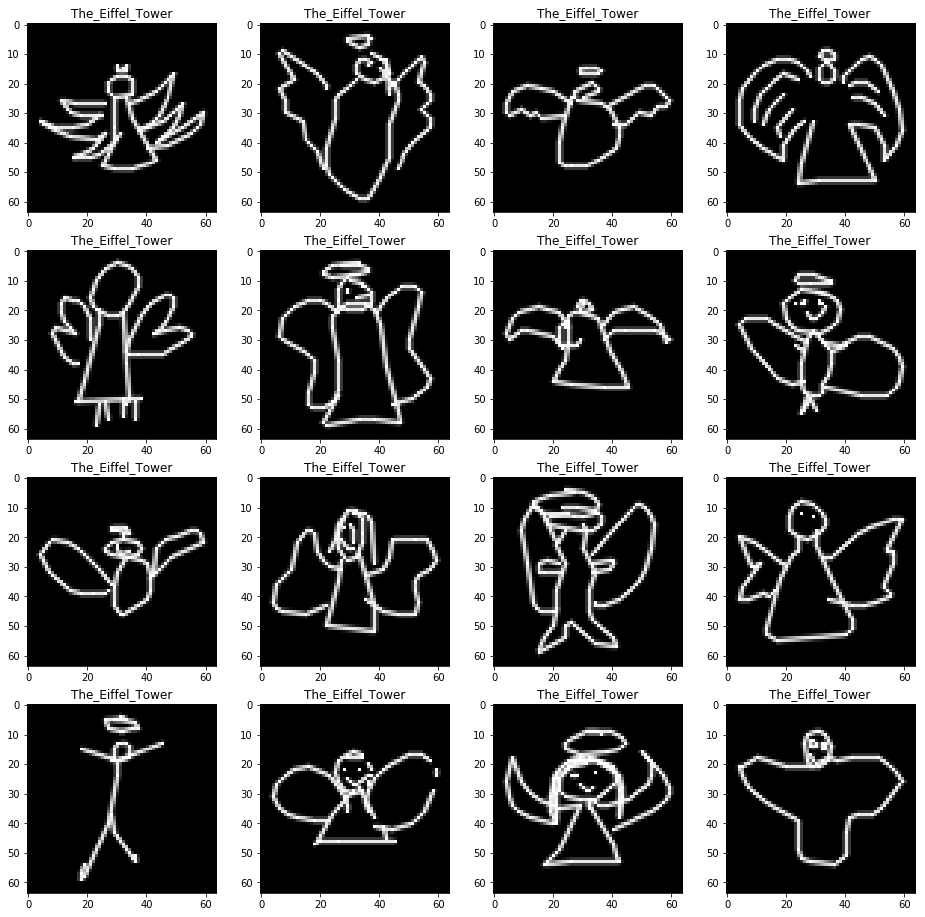

In [40]:
draw_a_batch()

In [12]:
def read_test_df(): 
    test_df = pd.read_csv('./test_%s.csv'%('simplified'))
    test_id = np.arange(0,len(test_df))

    return test_id

In [13]:
test_id = read_test_df()

In [14]:
len(test_id)

112199